        Stage  Control Mean  Control SD  Intervention Mean  Intervention SD
0         MCI      1.080295    0.582359           1.358412         0.832076
1      MildAD      5.082754    1.893136           5.474581         2.161474
2  ModerateAD      0.963083    1.642339           0.485853         1.409161
3    SevereAD      0.000000    0.000000           0.000000         0.000000


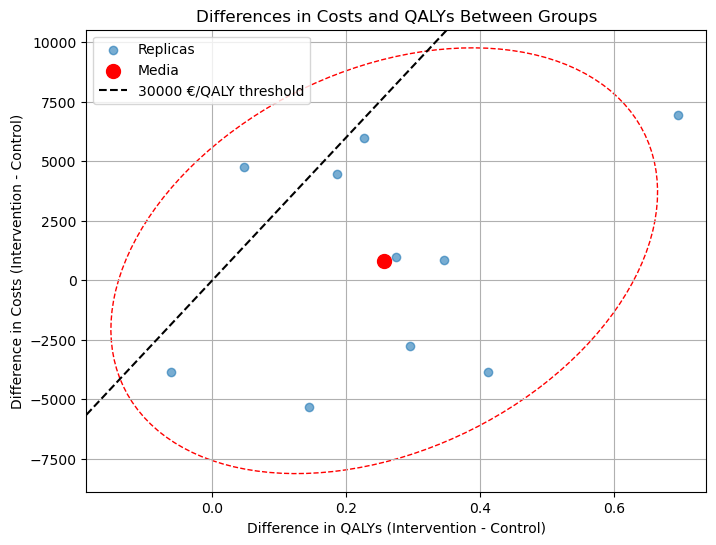

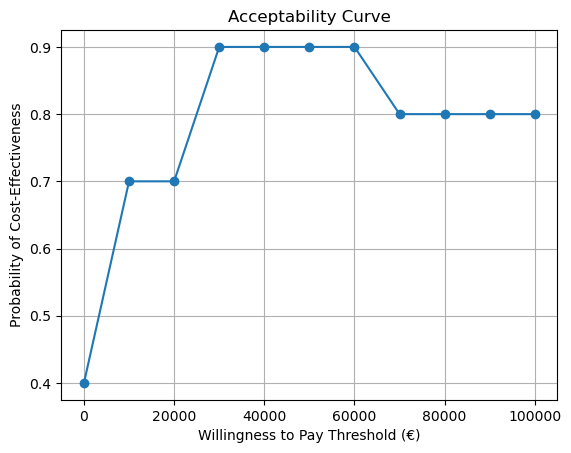

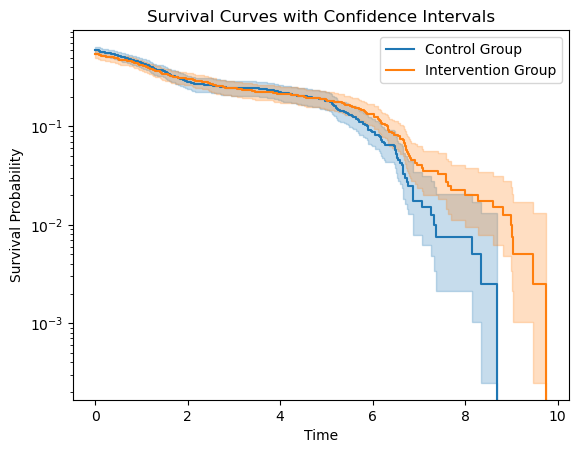

In [5]:
import random
import simpy
import numpy as np
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd
from lifelines import KaplanMeierFitter

# Parameters that must be specified by the user
REPLICATIONS = 10  # Specify the number of replications
PATIENTS = 10  # Specify the number of patients
DISCOUNT_RATE = 0.035  # Specify the discount rate for both Costs and Qualys
INFORMAL_COSTS = "no"  # Do you want to include informal costs in the analysis?
DX_COSTS = "no"  # Do you want to include diagnostic costs in the analysis?
INCLUDE_CAREGIVER_QOL = "no"  # Do you want to include caregivers QoL in the analysis?
pMALE = 0.6  # Define the percentage of males

# Parameters for describing the natural history of the disease
CUT_OFF_MILD_AD = 4.5
CUT_OFF_MODERATE_AD = 9.5
CUT_OFF_SEVERE_AD = 16

# Parameters for describing CDR-SB evolution
bB = np.array([5.260005139, 0.57640898700, 0.0089843680, -0.12776127300, -0.16889013300])
C = np.array([
    [0.32734000, -0.00005823586, -0.0064335612, -0.01177737000, 0.00005823586], 
    [0.00000000, 0.04102823100, 0.0004554976, -0.00001671691, -0.04102823000], 
    [0.00000000, 0.00000000000, 0.0567232474, -0.00102812300, -0.00033606900], 
    [0.00000000, 0.00000000000, 0.0000000000, 0.00104080300, -0.00104080300], 
    [0.00000000, 0.000000000000, 0.0000000000, 0.00000000000, 0.0410255600]
])
m1 = 0.4973 
m2 = 0.4521

# Parameters describing AD survival
S = np.array([
    [-87.38, 111.8], 
    [3.742, -2.560], 
    [-0.04759, 0.01877], 
    [0.0001903, -0.00004246]
])

# Parameters for defining population's socioeconomic parameters
mean_Age = 72.72
sd_Age = 6.58
mean_bMMSE = 27.30
sd_bMMSE = 2.40
mean_bCDR = 1.70
sd_bCDR = 0.15
alfaMaleTOC = math.exp(-8.92429766221)
betaMaleTOC = 0.075684416915906
alfaFemaleTOC = math.exp(-9.56691291810032)
betaFemaleTOC = 0.079076159880673

# Parameters for obtaining patients' costs
DIAGNOSTIC_TEST_COST = 2900  # Cost of AD disease diagnosis
TRT_COST = 5000  # Annual treatment cost
mean_MCI_COST_STAGE = 29551  # Annual cost of the Mild Cognitive Impairment Stage
sd_MCI_COST_STAGE = 7587
mean_MildAD_COST_STAGE = 38525  # Annual cost of the Mild AD Stage
sd_MildAD_COST_STAGE = 6792
mean_ModerateAD_COST_STAGE = 53920  # Annual cost of the Moderate AD Stage
sd_ModerateAD_COST_STAGE = 8456
mean_SevereAD_COST_STAGE = 74750  # Annual cost of the Severe AD Stage
sd_SevereAD_COST_STAGE = 7878

alfa_MCI_COST_STAGE = mean_MCI_COST_STAGE**2 / sd_MCI_COST_STAGE**2
beta_MCI_COST_STAGE = sd_MCI_COST_STAGE**2 / mean_MCI_COST_STAGE
alfa_MildAD_COST_STAGE = mean_MildAD_COST_STAGE**2 / sd_MildAD_COST_STAGE**2
beta_MildAD_COST_STAGE = sd_MildAD_COST_STAGE**2 / mean_MildAD_COST_STAGE
alfa_ModerateAD_COST_STAGE = mean_ModerateAD_COST_STAGE**2 / sd_ModerateAD_COST_STAGE**2
beta_ModerateAD_COST_STAGE = sd_ModerateAD_COST_STAGE**2 / mean_ModerateAD_COST_STAGE
alfa_SevereAD_COST_STAGE = mean_SevereAD_COST_STAGE**2 / sd_SevereAD_COST_STAGE**2
beta_SevereAD_COST_STAGE = sd_SevereAD_COST_STAGE**2 / mean_SevereAD_COST_STAGE

# Parameters for obtaining patients' QoL
mean_MCI_UTILITY_BELOW_30 = 0.91 
mean_MCI_UTILITY_BETWEEN_30_39 = 0.90
mean_MCI_UTILITY_BETWEEN_40_49 = 0.84
mean_MCI_UTILITY_BETWEEN_50_59 = 0.91
mean_MCI_UTILITY_BETWEEN_60_69 = 0.90
mean_MCI_UTILITY_BETWEEN_70_79 = 0.84
mean_MCI_UTILITY_BETWEEN_80_89 = 0.72
mean_MCI_UTILITY_ABOVE_90 = 0.58
mean_MILD_AD_UTILITY = 0.69
mean_MODERATE_AD_UTILITY = 0.53
mean_SEVERE_AD_UTILITY = 0.38

class Patient:
    def __init__(self, env, id, group, control_duration_MCI, control_duration_mild, control_duration_moderate, control_duration_severe, control_group_durations, 
                 intervention_duration_MCI, intervention_duration_mild, intervention_duration_moderate, intervention_duration_severe, intervention_group_durations, B, 
                 MCI_COST_STAGE, MildAD_COST_STAGE, ModerateAD_COST_STAGE, SevereAD_COST_STAGE, 
                 MCI_UTILITY_BELOW_30, MCI_UTILITY_BETWEEN_30_39, MCI_UTILITY_BETWEEN_40_49, MCI_UTILITY_BETWEEN_50_59, 
                 MCI_UTILITY_BETWEEN_60_69, MCI_UTILITY_BETWEEN_70_79, MCI_UTILITY_BETWEEN_80_89, MCI_UTILITY_ABOVE_90, 
                 MILD_AD_UTILITY, MODERATE_AD_UTILITY, SEVERE_AD_UTILITY, cloned_parameters=None):
        self.env = env
        self.id = id
        self.group = group
        self.control_duration_MCI = control_duration_MCI
        self.control_duration_mild = control_duration_mild
        self.control_duration_moderate = control_duration_moderate
        self.control_duration_severe = control_duration_severe
        self.control_group_durations = control_group_durations
        self.intervention_duration_MCI = intervention_duration_MCI
        self.intervention_duration_mild = intervention_duration_mild
        self.intervention_duration_moderate = intervention_duration_moderate
        self.intervention_duration_severe = intervention_duration_severe
        self.intervention_group_durations = intervention_group_durations
        self.B = B
        self.MCI_COST_STAGE = MCI_COST_STAGE
        self.MildAD_COST_STAGE = MildAD_COST_STAGE
        self.ModerateAD_COST_STAGE = ModerateAD_COST_STAGE
        self.SevereAD_COST_STAGE = SevereAD_COST_STAGE
        self.MCI_UTILITY_BELOW_30 = MCI_UTILITY_BELOW_30
        self.MCI_UTILITY_BETWEEN_30_39 = MCI_UTILITY_BETWEEN_30_39
        self.MCI_UTILITY_BETWEEN_40_49 = MCI_UTILITY_BETWEEN_40_49
        self.MCI_UTILITY_BETWEEN_50_59 = MCI_UTILITY_BETWEEN_50_59
        self.MCI_UTILITY_BETWEEN_60_69 = MCI_UTILITY_BETWEEN_60_69
        self.MCI_UTILITY_BETWEEN_70_79 = MCI_UTILITY_BETWEEN_70_79
        self.MCI_UTILITY_BETWEEN_80_89 = MCI_UTILITY_BETWEEN_80_89
        self.MCI_UTILITY_ABOVE_90 = MCI_UTILITY_ABOVE_90
        self.MILD_AD_UTILITY = MILD_AD_UTILITY
        self.MODERATE_AD_UTILITY = MODERATE_AD_UTILITY
        self.SEVERE_AD_UTILITY = SEVERE_AD_UTILITY
        
        if cloned_parameters is None:
            self.socioeconomic_parameters = self.generate_socioeconomic_parameters()
        else:
            self.socioeconomic_parameters = cloned_parameters
        
        self.onsets = self.generate_disease_stages_onset()
        self.alive = True
        self.current_stage = 'MCI'
        self.action = env.process(self.run())
        self.costs = 0  # Initialize costs if this attribute is used
        self.qalys = 0  # Initialize qalys if this attribute is used

        # Add attributes to track survival time in each stage
        self.survival_times = {'MCI': 0, 'MildAD': 0, 'ModerateAD': 0, 'SevereAD': 0}

    def generate_socioeconomic_parameters(self):
        # Generate socioeconomic parameters
        sex = np.random.choice([0, 1], p=[pMALE, 1-pMALE])
        ageIn = np.random.normal(mean_Age, sd_Age)
        bMMSE = np.random.normal(mean_bMMSE, sd_bMMSE)
        bCDR = np.random.normal(mean_bCDR, sd_bCDR)
        u = np.random.random()

        if sex == 0:
            alfa = alfaMaleTOC
            beta = betaMaleTOC
        else:
            alfa = alfaFemaleTOC
            beta = betaFemaleTOC

        AgeTOC = ageIn + (1 / beta) * np.log(1 - (beta / alfa) * np.log(1 - u) * np.exp(-beta * ageIn))
    
        return {'sex': sex, 'ageIn': ageIn, 'bMMSE': bMMSE, 'bCDR': bCDR, 'AgeTOC': AgeTOC}

    def generate_disease_stages_onset(self):
        ageIn = self.socioeconomic_parameters['ageIn']
        bCDR = self.socioeconomic_parameters['bCDR']
        bMMSE = self.socioeconomic_parameters['bMMSE']
        sex = self.socioeconomic_parameters['sex']
        group = self.group

        b0 = np.random.random() * m1
        b1 = np.random.random() * m2

        B = self.B
        
        AgeTOC = self.socioeconomic_parameters['AgeTOC']
        AgeMildAD = ageIn + ((CUT_OFF_MILD_AD - bCDR - B[0] - B[2] * group - B[3] * bMMSE - b0) / (B[1] + B[4] * group + b1))        
        AgeModerateAD = ageIn + ((CUT_OFF_MODERATE_AD - bCDR - B[0] - B[2] * group - B[3] * bMMSE - b0) / (B[1] + B[4] * group + b1))
        
        if self.group == 1 and self.id < len(self.control_group_durations): # Ensure there is a corresponding control patient
            # For the intervention group modify AgeSevereAD based on the control group duration
            control_duration = self.control_group_durations[self.id]
            AgeSevereAD = AgeModerateAD + control_duration
        else:
            AgeSevereAD = ageIn + ((CUT_OFF_SEVERE_AD - bCDR - B[0] - B[2] * group - B[3] * bMMSE - b0) / (B[1] + B[4] * group + b1))
        
        AgeTAD = AgeMildAD + (S[0, sex] + S[1, sex] * AgeMildAD + S[2, sex] * AgeMildAD**2 + S[3, sex] * AgeMildAD**3)

        # Store Moderate duration for control group
        if self.group == 0:
            self.control_duration_MCI.append(AgeMildAD - ageIn)
            self.control_duration_mild.append(AgeModerateAD - AgeMildAD)
            self.control_duration_moderate.append(AgeSevereAD - AgeModerateAD)
            self.control_duration_severe.append(min(AgeTAD, AgeTOC) - AgeSevereAD)
            self.control_group_durations.append(min(AgeTAD, AgeTOC) - ageIn)
        else:
            self.intervention_duration_MCI.append(AgeMildAD - ageIn)
            self.intervention_duration_mild.append(AgeModerateAD - AgeMildAD)
            self.intervention_duration_moderate.append(AgeSevereAD - AgeModerateAD)
            self.intervention_duration_severe.append(min(AgeTAD, AgeTOC) - AgeSevereAD)
            self.intervention_group_durations.append(min(AgeTAD, AgeTOC) - ageIn)
        
        return {'AgeMildAD': AgeMildAD, 'AgeModerateAD': AgeModerateAD, 'AgeSevereAD': AgeSevereAD, 'AgeTAD': AgeTAD, 'AgeTOC': AgeTOC}

    def run(self):
        self.current_age = self.socioeconomic_parameters['ageIn']
        onsets = self.onsets
        stages = ['MCI', 'MildAD', 'ModerateAD', 'SevereAD']

        while self.alive:
            next_event_age = min(onsets.values())
            key_next_event = min(onsets, key=onsets.get)
            duration = next_event_age - self.current_age
            if duration <= 0:
                duration = 0.5  # Small positive value to avoid zero timeout
            
            self.calculate_costs(self.current_stage, duration)
            self.calculate_qalys(self.current_stage, duration)

            # Track survival time in each stage
            self.survival_times[self.current_stage] += duration

            yield self.env.timeout(duration)
            self.current_age = next_event_age

            if 'AgeTOC' in onsets and self.current_age == onsets['AgeTOC'] or 'AgeTAD' in onsets and self.current_age == onsets['AgeTAD']:
                self.alive = False
                break
            elif 'AgeMildAD' in onsets and self.current_age == onsets['AgeMildAD']:
                self.current_stage = 'MildAD'
            elif 'AgeModerateAD' in onsets and self.current_age == onsets['AgeModerateAD']:
                self.current_stage = 'ModerateAD'
            elif 'AgeSevereAD' in onsets and self.current_age == onsets['AgeSevereAD']:
                self.current_stage = 'SevereAD'
            else:
                print("Something went wrong")
            
            del onsets[key_next_event]

    def calculate_costs(self, current_stage, duration):
        MCI_COST = self.MCI_COST_STAGE + TRT_COST
        MildAD_COST = self.MildAD_COST_STAGE + TRT_COST
        stage_cost_per_year = {
            'MCI': MCI_COST,
            'MildAD': MildAD_COST,
            'ModerateAD': self.ModerateAD_COST_STAGE,
            'SevereAD': self.SevereAD_COST_STAGE
        }
        self.costs += stage_cost_per_year[current_stage] * duration

    def calculate_qalys(self, current_stage, duration):
        if self.current_age < 30:
            MCI_UTILITY = self.MCI_UTILITY_BELOW_30
        elif self.current_age >= 30 and self.current_age < 40:
            MCI_UTILITY = self.MCI_UTILITY_BETWEEN_30_39
        elif self.current_age >= 40 and self.current_age < 50:
            MCI_UTILITY = self.MCI_UTILITY_BETWEEN_40_49
        elif self.current_age >= 50 and self.current_age < 60:
            MCI_UTILITY = self.MCI_UTILITY_BETWEEN_50_59
        elif self.current_age >= 60 and self.current_age < 70:
            MCI_UTILITY = self.MCI_UTILITY_BETWEEN_60_69
        elif self.current_age >= 70 and self.current_age < 80:
            MCI_UTILITY = self.MCI_UTILITY_BETWEEN_70_79
        elif self.current_age >= 80 and self.current_age < 90:
            MCI_UTILITY = self.MCI_UTILITY_BETWEEN_80_89
        else:
            MCI_UTILITY = self.MCI_UTILITY_ABOVE_90 
            
        stage_qaly_per_year = {
            'MCI': MCI_UTILITY,
            'MildAD': self.MILD_AD_UTILITY,
            'ModerateAD': self.MODERATE_AD_UTILITY,
            'SevereAD': self.SEVERE_AD_UTILITY
        }
        self.qalys += stage_qaly_per_year[current_stage] * duration

def simulate(env, PATIENTS, control_duration_MCI, control_duration_mild, control_duration_moderate, control_duration_severe, control_group_durations, 
             intervention_duration_MCI, intervention_duration_mild, intervention_duration_moderate, intervention_duration_severe, intervention_group_durations, B):
    control_group = [Patient(env, i, 0, control_duration_MCI, control_duration_mild, control_duration_moderate, control_duration_severe, control_group_durations,
                             intervention_duration_MCI, intervention_duration_mild, intervention_duration_moderate, intervention_duration_severe, intervention_group_durations, B,
                             MCI_COST_STAGE, MildAD_COST_STAGE, ModerateAD_COST_STAGE, SevereAD_COST_STAGE,
                             MCI_UTILITY_BELOW_30, MCI_UTILITY_BETWEEN_30_39, MCI_UTILITY_BETWEEN_40_49,
                             MCI_UTILITY_BETWEEN_50_59, MCI_UTILITY_BETWEEN_60_69, MCI_UTILITY_BETWEEN_70_79,
                             MCI_UTILITY_BETWEEN_80_89, MCI_UTILITY_ABOVE_90, MILD_AD_UTILITY, MODERATE_AD_UTILITY,
                             SEVERE_AD_UTILITY) for i in range(PATIENTS)]  # Control group
    intervention_group = [Patient(env, i, 1, control_duration_MCI, control_duration_mild, control_duration_moderate, control_duration_severe, control_group_durations,
                                  intervention_duration_MCI, intervention_duration_mild, intervention_duration_moderate, intervention_duration_severe, intervention_group_durations, B,
                                  MCI_COST_STAGE, MildAD_COST_STAGE, ModerateAD_COST_STAGE, SevereAD_COST_STAGE,
                                  MCI_UTILITY_BELOW_30, MCI_UTILITY_BETWEEN_30_39, MCI_UTILITY_BETWEEN_40_49,
                                  MCI_UTILITY_BETWEEN_50_59, MCI_UTILITY_BETWEEN_60_69, MCI_UTILITY_BETWEEN_70_79,
                                  MCI_UTILITY_BETWEEN_80_89, MCI_UTILITY_ABOVE_90, MILD_AD_UTILITY, MODERATE_AD_UTILITY,
                                  SEVERE_AD_UTILITY, cloned_parameters=control_group[i].socioeconomic_parameters) for i in range(PATIENTS)]  # Intervention group
    yield env.all_of([patient.action for patient in control_group + intervention_group])

def main(PATIENTS, REPLICATIONS):
    results = []
    for rep in range(REPLICATIONS):
        # Parametric uncertainty of Mixed model for CDR-SB
        Z = np.random.randn(bB.size)  # Generate random vector Z
        B = bB + C @ Z  # Update B with Cholesky decomposition for second-order uncertainty for mixed models

        random_value = np.random.rand()
        # Parametric uncertainty of costs
        MCI_COST_STAGE = stats.gamma.ppf(random_value, alfa_MCI_COST_STAGE, scale=beta_MCI_COST_STAGE)
        MildAD_COST_STAGE = stats.gamma.ppf(random_value, alfa_MildAD_COST_STAGE, scale=beta_MildAD_COST_STAGE)
        ModerateAD_COST_STAGE = stats.gamma.ppf(random_value, alfa_ModerateAD_COST_STAGE, scale=beta_ModerateAD_COST_STAGE)  
        SevereAD_COST_STAGE = stats.gamma.ppf(random_value, alfa_SevereAD_COST_STAGE, scale=beta_SevereAD_COST_STAGE)

        # Parametric uncertainty of qalys
        MCI_UTILITY_BELOW_30 = stats.beta.ppf(random_value, mean_MCI_UTILITY_BELOW_30 * 100, 100 - mean_MCI_UTILITY_BELOW_30 * 100) 
        MCI_UTILITY_BETWEEN_30_39 = stats.beta.ppf(random_value, mean_MCI_UTILITY_BETWEEN_30_39 * 100, 100 - mean_MCI_UTILITY_BETWEEN_30_39 * 100)
        MCI_UTILITY_BETWEEN_40_49 = stats.beta.ppf(random_value, mean_MCI_UTILITY_BETWEEN_40_49 * 100, 100 - mean_MCI_UTILITY_BETWEEN_40_49 * 100)
        MCI_UTILITY_BETWEEN_50_59 = stats.beta.ppf(random_value, mean_MCI_UTILITY_BETWEEN_50_59 * 100, 100 - mean_MCI_UTILITY_BETWEEN_50_59 * 100)
        MCI_UTILITY_BETWEEN_60_69 = stats.beta.ppf(random_value, mean_MCI_UTILITY_BETWEEN_60_69 * 100, 100 - mean_MCI_UTILITY_BETWEEN_60_69 * 100)
        MCI_UTILITY_BETWEEN_70_79 = stats.beta.ppf(random_value, mean_MCI_UTILITY_BETWEEN_70_79 * 100, 100 - mean_MCI_UTILITY_BETWEEN_70_79 * 100)
        MCI_UTILITY_BETWEEN_80_89 = stats.beta.ppf(random_value, mean_MCI_UTILITY_BETWEEN_80_89 * 100, 100 - mean_MCI_UTILITY_BETWEEN_80_89 * 100)
        MCI_UTILITY_ABOVE_90 = stats.beta.ppf(random_value, mean_MCI_UTILITY_ABOVE_90 * 100, 100 - mean_MCI_UTILITY_ABOVE_90 * 100)
        MILD_AD_UTILITY = stats.beta.ppf(random_value, mean_MILD_AD_UTILITY * 100, 100 - mean_MILD_AD_UTILITY * 100)
        MODERATE_AD_UTILITY = stats.beta.ppf(random_value, mean_MODERATE_AD_UTILITY * 100, 100 - mean_MODERATE_AD_UTILITY * 100)
        SEVERE_AD_UTILITY = stats.beta.ppf(random_value, mean_SEVERE_AD_UTILITY * 100, 100 - mean_SEVERE_AD_UTILITY * 100)

        env = simpy.Environment()
        control_duration_MCI = []
        control_duration_mild = []
        control_duration_moderate = []
        control_duration_severe = []
        control_group_durations = []
        intervention_duration_MCI = []
        intervention_duration_mild = []
        intervention_duration_moderate = []
        intervention_duration_severe = []
        intervention_group_durations = []

        control_group = [
            Patient(env, i, 0, control_duration_MCI, control_duration_mild, control_duration_moderate,  control_duration_severe, control_group_durations,
                    intervention_duration_MCI, intervention_duration_mild, intervention_duration_moderate, intervention_duration_severe, intervention_group_durations, B,
                    MCI_COST_STAGE, MildAD_COST_STAGE, ModerateAD_COST_STAGE, SevereAD_COST_STAGE,
                    MCI_UTILITY_BELOW_30, MCI_UTILITY_BETWEEN_30_39, MCI_UTILITY_BETWEEN_40_49,
                    MCI_UTILITY_BETWEEN_50_59, MCI_UTILITY_BETWEEN_60_69, MCI_UTILITY_BETWEEN_70_79,
                    MCI_UTILITY_BETWEEN_80_89, MCI_UTILITY_ABOVE_90, MILD_AD_UTILITY, MODERATE_AD_UTILITY,
                    SEVERE_AD_UTILITY)
            for i in range(PATIENTS)
        ]
        
        intervention_group = [
            Patient(env, i, 1, control_duration_MCI, control_duration_mild, control_duration_moderate, control_duration_severe, control_group_durations,
                    intervention_duration_MCI, intervention_duration_mild, intervention_duration_moderate, intervention_duration_severe, intervention_group_durations, B,
                    MCI_COST_STAGE, MildAD_COST_STAGE, ModerateAD_COST_STAGE, SevereAD_COST_STAGE,
                    MCI_UTILITY_BELOW_30, MCI_UTILITY_BETWEEN_30_39, MCI_UTILITY_BETWEEN_40_49,
                    MCI_UTILITY_BETWEEN_50_59, MCI_UTILITY_BETWEEN_60_69, MCI_UTILITY_BETWEEN_70_79,
                    MCI_UTILITY_BETWEEN_80_89, MCI_UTILITY_ABOVE_90, MILD_AD_UTILITY, MODERATE_AD_UTILITY,
                    SEVERE_AD_UTILITY, cloned_parameters=control_group[i].socioeconomic_parameters)
            for i in range(PATIENTS)
        ]
        
        env.run()
        
        control_costs = [patient.costs for patient in control_group]
        intervention_costs = [patient.costs for patient in intervention_group]
        control_qalys = [patient.qalys for patient in control_group]
        intervention_qalys = [patient.qalys for patient in intervention_group]
        
        # Collect survival times per stage
        control_survival_times = {stage: [] for stage in ['MCI', 'MildAD', 'ModerateAD', 'SevereAD']}
        intervention_survival_times = {stage: [] for stage in ['MCI', 'MildAD', 'ModerateAD', 'SevereAD']}
        
        for patient in control_group:
            for stage in control_survival_times:
                control_survival_times[stage].append(patient.survival_times[stage])
        
        for patient in intervention_group:
            for stage in intervention_survival_times:
                intervention_survival_times[stage].append(patient.survival_times[stage])
        
        # Calculate incremental costs and qalys
        incremental_costs = np.mean(intervention_costs) - np.mean(control_costs)
        incremental_qalys = np.mean(intervention_qalys) - np.mean(control_qalys)

        results.append({
            'control_costs': control_costs,
            'intervention_costs': intervention_costs,
            'control_qalys': control_qalys,
            'intervention_qalys': intervention_qalys,
            'control_survival_times': control_survival_times,
            'intervention_survival_times': intervention_survival_times,
            'incremental_costs': incremental_costs,
            'incremental_qalys': incremental_qalys
        })
    return results

# Calcula el RCEI para cada réplica
def calculate_rcei(results):
    rceis = []
    for result in results:
        delta_costs = np.mean(result['intervention_costs']) - np.mean(result['control_costs'])
        delta_qalys = np.mean(result['intervention_qalys']) - np.mean(result['control_qalys'])
        if delta_qalys != 0:
            rcei = delta_costs / delta_qalys
        else:
            rcei = np.inf  # Manejar divisiones por cero
        rceis.append(rcei)
    return rceis

# Calcula la media y los intervalos de confianza del RCEI
def rcei_statistics(rceis):
    mean_rcei = np.mean(rceis)
    ci_low, ci_high = np.percentile(rceis, [2.5, 97.5])
    return mean_rcei, ci_low, ci_high

# Función para añadir una elipse de confianza al 95%
def confidence_ellipse(x, y, ax, n_std=1.96, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("Las longitudes de x e y deben ser iguales")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = plt.matplotlib.transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(np.mean(x), np.mean(y))

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def aggregate_survival_times_by_stage(results):
    # Initialize dictionaries to store survival times by stage
    control_survival_times = {stage: [] for stage in ['MCI', 'MildAD', 'ModerateAD', 'SevereAD']}
    intervention_survival_times = {stage: [] for stage in ['MCI', 'MildAD', 'ModerateAD', 'SevereAD']}
    
    # Combine survival times across all replications for each stage
    for result in results:
        for stage in control_survival_times.keys():
            control_survival_times[stage].extend(result['control_survival_times'][stage])
            intervention_survival_times[stage].extend(result['intervention_survival_times'][stage])
    
    return control_survival_times, intervention_survival_times

def create_survival_summary_table(control_survival_times, intervention_survival_times):
    # Create a summary table with mean and standard deviation for each stage and group
    summary_data = []
    for stage in control_survival_times.keys():
        control_mean = np.mean(control_survival_times[stage])
        control_std = np.std(control_survival_times[stage])
        intervention_mean = np.mean(intervention_survival_times[stage])
        intervention_std = np.std(intervention_survival_times[stage])
        
        summary_data.append({
            'Stage': stage,
            'Control Mean': control_mean,
            'Control SD': control_std,
            'Intervention Mean': intervention_mean,
            'Intervention SD': intervention_std
        })
    
    # Convert the summary data to a DataFrame for better readability
    summary_df = pd.DataFrame(summary_data)
    
    return summary_df

def downsample_data(data, target_size=10000):
    """Downsamples the data to a target size by randomly selecting points."""
    if len(data) > target_size:
        indices = np.random.choice(len(data), size=target_size, replace=False)
        return [data[i] for i in indices]
    return data

def plot_survival_curve_with_confidence_intervals(control_survival_times, intervention_survival_times):
    kmf_control = KaplanMeierFitter()
    kmf_intervention = KaplanMeierFitter()
    
    # Combine all stages' survival times into one list per group
    all_control_survival = [time for stage in control_survival_times for time in control_survival_times[stage]]
    all_intervention_survival = [time for stage in intervention_survival_times for time in intervention_survival_times[stage]]
    
    # Downsample the data if needed
    all_control_survival = downsample_data(all_control_survival)
    all_intervention_survival = downsample_data(all_intervention_survival)
    
    # Plot the survival functions with confidence intervals
    kmf_control.fit(all_control_survival, label="Control Group")
    ax = kmf_control.plot_survival_function(ci_show=True)
    
    kmf_intervention.fit(all_intervention_survival, label="Intervention Group")
    kmf_intervention.plot_survival_function(ci_show=True, ax=ax)
    
    plt.title('Survival Curves with Confidence Intervals')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.yscale('log')  # Optional: Apply logarithmic scale if appropriate
    plt.show()


# Modifica plot_differences para incluir el RCEI, la media y la elipse de confianza
def plot_differences_with_rcei_and_ellipse(results):
    # Calculate differences
    rceis = calculate_rcei(results)
    mean_rcei, ci_low, ci_high = rcei_statistics(rceis)

    cost_diffs = []
    qaly_diffs = []

    for result in results:
        avg_control_costs = sum(result['control_costs']) / len(result['control_costs'])
        avg_intervention_costs = sum(result['intervention_costs']) / len(result['intervention_costs'])
        avg_control_qalys = sum(result['control_qalys']) / len(result['control_qalys'])
        avg_intervention_qalys = sum(result['intervention_qalys']) / len(result['intervention_qalys'])

        cost_diffs.append(avg_intervention_costs - avg_control_costs)
        qaly_diffs.append(avg_intervention_qalys - avg_control_qalys)

    # Create the figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.scatter(qaly_diffs, cost_diffs, label='Replicas', alpha=0.6)
    ax.set_xlabel('Difference in QALYs (Intervention - Control)')
    ax.set_ylabel('Difference in Costs (Intervention - Control)')
    ax.set_title('Differences in Costs and QALYs Between Groups')
    ax.grid(True)

    # Mean point and threshold line
    mean_qaly_diff = np.mean(qaly_diffs)
    mean_cost_diff = np.mean(cost_diffs)
    ax.scatter(mean_qaly_diff, mean_cost_diff, color='red', label='Mean', s=100, zorder=5)
    ax.axline((0, 0), slope=30000, color='black', linestyle='--', label='30000 €/QALY threshold')

    # Confidence ellipse
    confidence_ellipse(np.array(qaly_diffs), np.array(cost_diffs), ax, n_std=1.96, edgecolor='red', linestyle='--')

    ax.legend()

    # Do not call plt.show()
    return fig  # Return the figure object

def acceptability_curve(results):
    thresholds = range(0, 100001, 10000)
    acceptability = []

    for threshold in thresholds:
        net_benefit = []
        for result in results:
            incremental_costs = result['incremental_costs']
            incremental_qalys = result['incremental_qalys']
            net_benefit_value = (threshold * incremental_qalys) - incremental_costs
            if net_benefit_value > 0:
                net_benefit.append(1)
            else:
                net_benefit.append(0)
        acceptability.append(np.mean(net_benefit))

    plt.plot(thresholds, acceptability, marker='o')
    plt.xlabel('Willingness to Pay Threshold (€)')
    plt.ylabel('Probability of Cost-Effectiveness')
    plt.title('Acceptability Curve')
    plt.grid(True)
    plt.show()



# Main simulation execution
results = main(PATIENTS, REPLICATIONS)

# Aggregate survival times by stage
control_survival_times, intervention_survival_times = aggregate_survival_times_by_stage(results)

# Create and display the survival summary table
summary_df = create_survival_summary_table(control_survival_times, intervention_survival_times)
print(summary_df)


plot_differences_with_rcei_and_ellipse(results)
acceptability_curve(results)

plot_survival_curve_with_confidence_intervals(control_survival_times, intervention_survival_times)
